# CC6: Dashboard of Unemployment - Across UK and the Nordic Countries

This notebook will batch download harmonised Monthly Harmonised Unemployment Rate, 15+ years, Seasonally Adjusted across Nordic countries and the UK (2015-2025).

**Data source:** FRED (Federal Reserve Economic Data) via OECD Main Economic Indicators

### API Documentation

**Base URL:** `https://api.stlouisfed.org/fred/series/observations`

**Required parameters:**
- `series_id`: The FRED series identifier (e.g., LRHUTTTTSEM156S)
- `api_key`: Your FRED API key
- `file_type`: Output format (json)

**Optional parameters:**
- `observation_start`: Start date (YYYY-MM-DD)
- `observation_end`: End date (YYYY-MM-DD)

**Example full URL:**
```
https://api.stlouisfed.org/fred/series/observations?series_id=LRHUTTTTSEM156S&api_key=YOUR_KEY&file_type=json&observation_start=2015-01-01

In [1]:
import requests
import json
import pandas as pd
from datetime import datetime

In [2]:
# FRED API configuration
API_KEY = "ec84959f0124fa43e3b547e8cf788a1a"  # Free FRED API key
BASE_URL = "https://api.stlouisfed.org/fred/series/observations"

# Date range for data
START_DATE = "2015-01-01"
END_DATE = "2025-12-31"

In [3]:
# Dictionary mapping country names to FRED series codes

series_dict = {
    "Sweden": "LRHUTTTTSEM156S",
    "Denmark": "LRHUTTTTDKM156S",
    "Finland": "LRHUTTTTFIM156S",
    "Iceland": "LRHUTTTTISM156S",
    "Norway": "LRHUTTTTNOM156S",
    "UK": "LRHUTTTTGBM156S"
}

print(f"Downloading {len(series_dict)} series from FRED API")
print(f"Date range: {START_DATE} to {END_DATE}")

Date range: 2015-01-01 to 2025-12-31


In [4]:
# Loop through each country and download data
all_data = {}

for country, series_id in series_dict.items():
    print(f"Downloading: {country} ({series_id})...")

    # Construct API URL
    url = f"{BASE_URL}?series_id={series_id}&api_key={API_KEY}&file_type=json&observation_start={START_DATE}&observation_end={END_DATE}"

    # Make API request
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        observations = data.get("observations", [])
        all_data[country] = observations
        print(f"  ✓ Retrieved {len(observations)} observations")
    else:
        print(f"  ✗ Error: {response.status_code}")

print(f"\nCompleted downloading {len(all_data)} series")

Downloading: Sweden (LRHUTTTTSEM156S)...
  ✓ Retrieved 130 observations
Downloading: Denmark (LRHUTTTTDKM156S)...
  ✓ Retrieved 130 observations
Downloading: Finland (LRHUTTTTFIM156S)...
  ✓ Retrieved 130 observations
Downloading: Iceland (LRHUTTTTISM156S)...
  ✓ Retrieved 130 observations
Downloading: Norway (LRHUTTTTNOM156S)...
  ✓ Retrieved 130 observations
Downloading: UK (LRHUTTTTGBM156S)...
  ✓ Retrieved 128 observations

Completed downloading 6 series


In [5]:
# Transform observations to Vega-Lite friendly format while filtering out missing values
def transform_to_vega_format(observations, country_name):
    transformed = []
    for obs in observations:
        if obs["value"] != ".":  # Skip missing values
            transformed.append({
                "date": obs["date"],
                "value": float(obs["value"]),
                "country": country_name
            })
    return transformed

In [6]:
# Transform and save each country's data as separate JSON file
for country, observations in all_data.items():
    vega_data = transform_to_vega_format(observations, country)
    filename = f"cc6_chart_{country.lower().replace(' ', '_')}.json"

    # Save to JSON file
    with open(filename, 'w') as f:
        json.dump(vega_data, f, indent=2)

    print(f"Saved: {filename} ({len(vega_data)} records)")

Saved: cc6_chart_sweden.json (130 records)
Saved: cc6_chart_denmark.json (130 records)
Saved: cc6_chart_finland.json (130 records)
Saved: cc6_chart_iceland.json (130 records)
Saved: cc6_chart_norway.json (130 records)
Saved: cc6_chart_uk.json (128 records)


In [9]:
# Combine all data into a single DataFrame for preview
all_records = []
for country, observations in all_data.items():
    for obs in observations:
        if obs["value"] != ".":
            all_records.append({
                "date": obs["date"],
                "value": float(obs["value"]),
                "country": country
            })

df = pd.DataFrame(all_records)
df["date"] = pd.to_datetime(df["date"])

print("Summary statistics:")
print(df.groupby("country")["value"].describe().round(2))

Summary statistics:
         count  mean   std  min   25%   50%  75%   max
country                                               
Denmark  130.0  5.54  0.75  4.0  4.93  5.70  6.1   7.0
Finland  130.0  8.03  1.06  5.9  7.10  8.15  8.9  10.3
Iceland  130.0  4.01  0.94  3.1  3.40  3.60  4.3   6.8
Norway   130.0  4.22  0.65  2.6  3.70  4.20  4.7   5.9
Sweden   130.0  7.69  0.89  5.9  7.00  7.50  8.4   9.6
UK       128.0  4.40  0.51  3.6  4.00  4.30  4.8   5.6


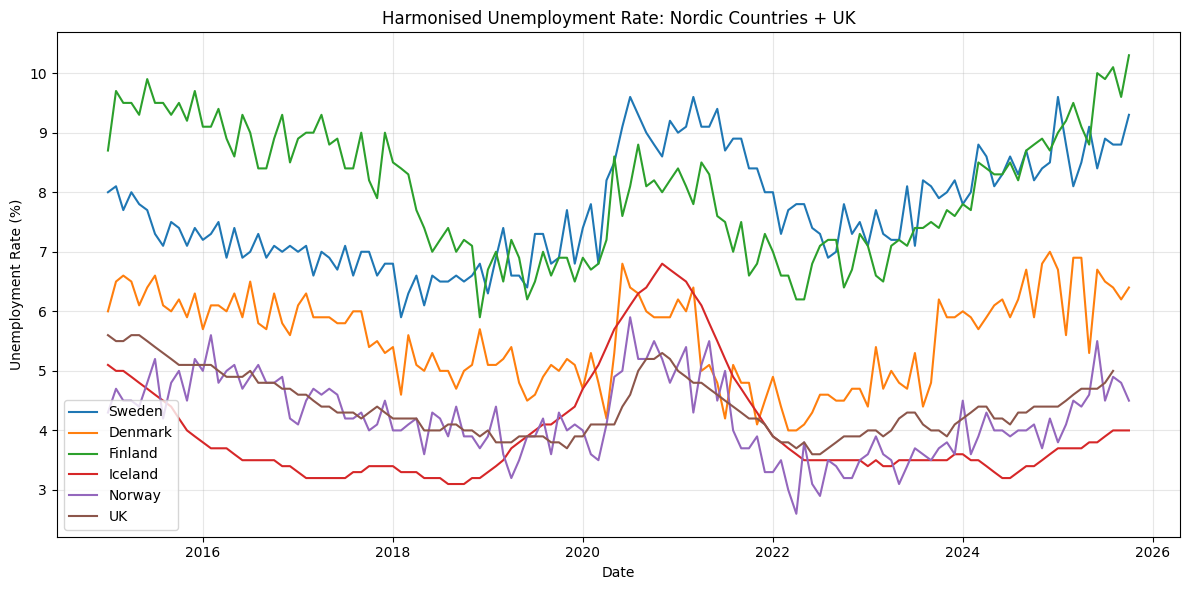

In [8]:
# Quick plot to verify data
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

for country in df["country"].unique():
    country_data = df[df["country"] == country]
    ax.plot(country_data["date"], country_data["value"], label=country)

ax.set_xlabel("Date")
ax.set_ylabel("Unemployment Rate (%)")
ax.set_title("Harmonised Unemployment Rate: Nordic Countries + UK")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# Download all JSON files
try:
    from google.colab import files
    for country in series_dict.keys():
        filename = f"cc6_chart_{country.lower().replace(' ', '_')}.json"
        files.download(filename)
        print(f"Downloaded: {filename}")
except ImportError:
    print("Not running in Colab - files saved to current directory")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>